In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pickle
import datetime
from utils.es_utils import *
from utils.env_utils import *
from utils.eval_utils import *
from utils.train_utils import *
from models.Buffer import Buffer
from models.PredatorPolicy import PredatorPolicy
from models.PredInteractionPolicy import PreyPolicy, PredInteractionPolicy
from models.ModularNetworks import PredatorInteraction
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from models.Buffer import Pool
from utils.env_utils import *
from utils.eval_utils import *
from utils.train_utils import pretrain_policy_with_validation
from custom_marl_aquarium.aquarium_v0 import parallel_env

In [2]:
# Create training folder
path = rf"..\data\2. Training\training\BC"
timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
folder_name = f"BC Training - {timestamp} - Couzin Data"
save_dir = os.path.join(path, folder_name)
os.makedirs(save_dir, exist_ok=True)

# Expert Data
traj_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\yolo_detected'
couzin_path = rf'..\data\1. Data Processing\processed\couzin'
hl_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\hand_labeled'
ftw_path = rf'..\data\1. Data Processing\processed\video\3. full_track_windows'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_policy = PredatorPolicy().to(device)
pred_policy.set_parameters(init=True)

prey_policy = PreyPolicy().to(device)
prey_policy.set_parameters(init=True)

expert_buffer = Buffer(pred_max_length=23000, prey_max_length=250000, device="cpu")

start_frame_pool = Pool(max_length=12100, device="cpu")
start_frame_pool.generate_startframes(ftw_path)
print(f"Start frames in pool: {len(start_frame_pool)}")

Start frames in pool: 11978


In [4]:
# Load Expert Data from local storage
print("Expert Buffer is empty, load data...")
expert_buffer.add_expert(couzin_path)
#expert_buffer.clear(p=80)               # Reduce ratio of non-attack data by 90%. now ~equal
#expert_buffer.add_expert(hl_path)       # hand-labeled data | Pred: 1057 | Prey: 33824

len_exp_pred, len_exp_prey, len_exp_pred_prey = expert_buffer.lengths()
print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey)
print("Storage of Prey Pred Expert Buffer: ", len_exp_pred_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  7510
Storage of Prey Expert Buffer:  240320
Storage of Prey Pred Expert Buffer:  240320 



In [5]:
pred_policy = pretrain_policy(pred_policy, expert_buffer, role="predator", pred_bs=1024, prey_bs=4096, prey_pred_bs=1024, epochs=500, lr=1e-3, device=device)

In [6]:
prey_policy = pretrain_policy(prey_policy, expert_buffer, role="prey", pred_bs=1024, prey_bs=4096, prey_pred_bs=1024, epochs=1000, lr=1e-3, device=device)

In [7]:
prey_pred_policy = PredInteractionPolicy().to(device)
prey_pred_policy.set_parameters(init=True)

prey_pred_policy = pretrain_policy(prey_pred_policy, expert_buffer, role="prey_pred", pred_bs=1024, prey_bs=4096, prey_pred_bs=4096, epochs=1000, lr=1e-3, device=device)

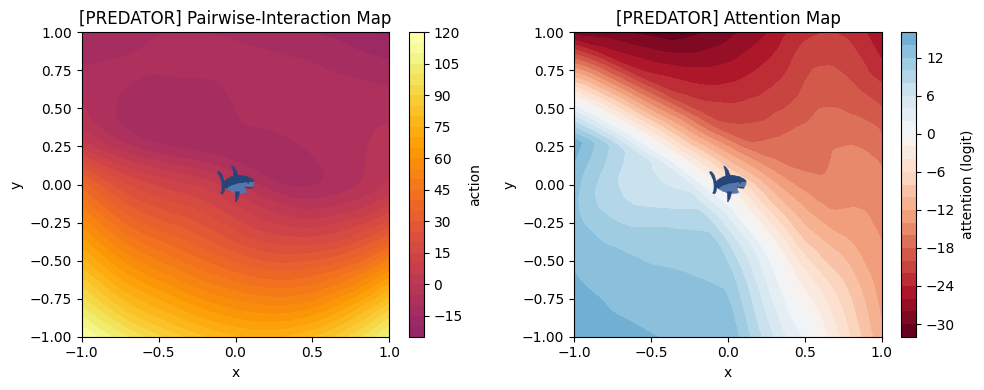

In [8]:
xs, ys, pred_action_map, pred_attn_map = compute_pin_an_maps(pin=pred_policy.pairwise, an=pred_policy.attention)

pred_img_path = rf"..\data\3. Evaluation\images\predator.png"
plot_policy_maps(xs, ys, pred_action_map, pred_attn_map, role="predator", img_path=pred_img_path)

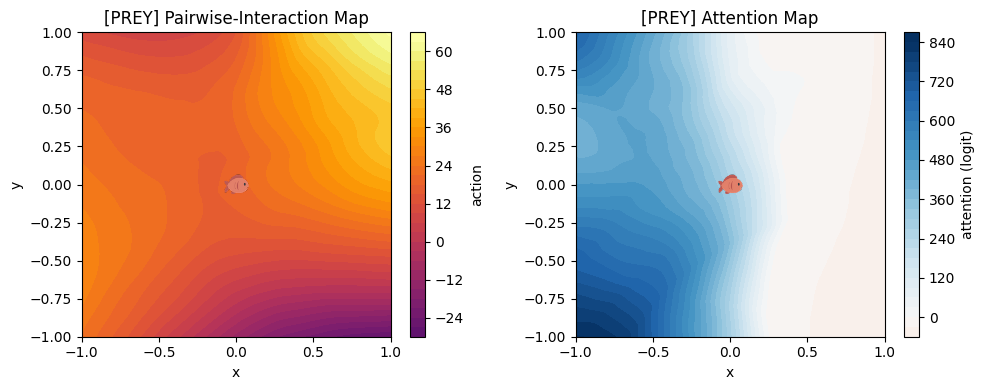

In [9]:
xs, ys, prey_action_map, prey_attn_map = compute_pin_an_maps(pin=prey_policy.prey_pairwise, an=prey_policy.prey_attention)

prey_img_path = rf"..\data\3. Evaluation\images\prey.png"
plot_policy_maps(xs, ys, prey_action_map, prey_attn_map, role="prey", img_path=prey_img_path)

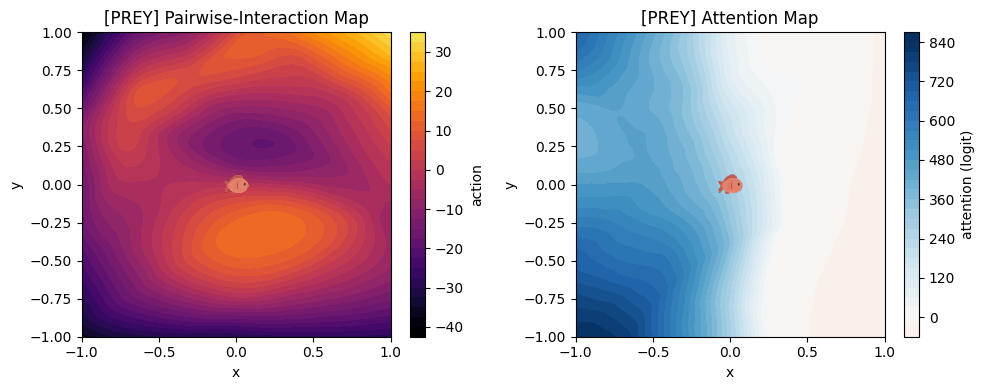

In [10]:
xs, ys, prey_action_map, prey_attn_map = compute_pin_an_maps(pin=prey_pred_policy.pred_pairwise, an=prey_policy.prey_attention)

prey_img_path = rf"..\data\3. Evaluation\images\prey.png"
plot_policy_maps(xs, ys, prey_action_map, prey_attn_map, role="prey", img_path=prey_img_path)

In [44]:
def run_policies2(env, pred_policy, prey_policy, prey_pred_policy, render=True):
    if render:
        print("Press 'q' to end simulation.")

    pred_policy.to("cpu")
    prey_policy.to("cpu")
    prey_pred_policy.to("cpu")

    while True:
        if render and keyboard.is_pressed('q'):
            break

        global_state = env.state().item()
        pred_tensor, prey_tensor, xs, ys, directions, dx, dy, vxs, vys = get_eval_features(global_state)

        pred_states = pred_tensor[..., :4]
        action_pred, mu_pred, sigma_pred, weights_pred = pred_policy.forward(pred_states)
        dis_pred = continuous_to_discrete(action_pred, 360, role='predator')

        prey_states = prey_tensor[..., :4]
        prey_action_per_prey, mu_log, sigma_log, weights_log = prey_policy.forward(prey_states)
        prey_action_from_pred, mu_pred_log, sigma_pred_log = prey_pred_policy.forward(prey_states)
        prey_action_from_pred = prey_action_from_pred[..., 0]
        prey_action_from_pred = prey_action_from_pred.mean(dim=1)

        # Weight Approach
        weights_pred = weights_pred
        w_min = weights_pred.min(dim=1, keepdim=True).values
        w_max = weights_pred.max(dim=1, keepdim=True).values
        weights = (weights_pred - w_min) / (w_max - w_min + 1e-8)

        # Distance Approach
        xs = torch.as_tensor(xs, dtype=torch.float32)
        ys = torch.as_tensor(ys, dtype=torch.float32)
        px, py = xs[0], ys[0]
        dists = torch.sqrt((xs - px)**2 + (ys - py)**2) # euclidean distance
        dists_norm = dists / (dists.max() + 1e-8)
        prey_dists = dists_norm[1:] #without predator

        final_action = (1.0 - prey_dists) * (prey_action_from_pred) + prey_dists * prey_action_per_prey

        dis_prey = continuous_to_discrete(final_action, 360, role='prey')


        # Action dictionary
        action_dict = {'predator_0': dis_pred}
        for i, agent_name in enumerate(sorted([agent for agent in env.agents if agent.startswith("prey")])):
            action_dict[agent_name] = dis_prey[i]

        env.step(action_dict)

        # Render only if user wants it
        if render:
            env.render()

    # Try closing the environment
    try:
        env.close()
    except:
        pass

In [ ]:
#env = parallel_env(use_walls=True, prey_max_velocity=4.0, predator_max_velocity=5.0, prey_count=32, width=800, height=800)

env = parallel_env(
    # Umgebung
    use_walls=True,
    width=800,
    height=800,

    # Sicht / Heuristiken
    predator_observe_count=1,
    prey_observe_count=32,

    # Kräfte / Limits (neutralisieren)
    prey_max_acceleration=1,
    predator_max_acceleration=1,
    prey_max_steer_force=360,
    predator_max_steer_force=360,

    # Bewegung (nur Policy-Vektor zählt)
    prey_max_velocity=4.0,
    predator_max_velocity=5.0,

    # Interaktionen ausschalten
    catch_radius=0,
    prey_reward=0,
    predator_reward=0,
    prey_punishment=0,

    # Agentenzahlen
    prey_count=20,
    max_prey_count=20,
)


positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
run_policies2(env, pred_policy, prey_policy, prey_pred_policy)

Press 'q' to end simulation.
